In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import itertools
import tensorflow as tf
import collections
import time
import random
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
from imblearn.over_sampling import RandomOverSampler

In [3]:
injury_rec_df = pd.read_pickle('Injury.plk')
injury_rec_df

,PlayerKey,GameID,PlayKey,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,1,1,1,1
...,...,...,...,...,...,...,...,...
100,44423,44423-13,NaN,Knee,1,0,0,0
101,31933,31933-20,NaN,Knee,1,0,0,0
102,47285,47285-4,NaN,Knee,1,1,0,0
103,37068,37068-19,NaN,Knee,1,1,0,0


In [4]:
playList_no_dups = pd.read_pickle('PlayList_No_Dups.plk')
playList_no_dups 

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB
81,26624,26624-2,26624-2-1,Quarterback,11,2,Indoor,Synthetic,85,Cloudy,Pass,1,QB,QB
157,26624,26624-3,26624-3-1,Quarterback,18,3,Outdoor,Synthetic,84,Clear,Rush,1,QB,QB
221,26624,26624-4,26624-4-1,Quarterback,25,4,Outdoor,Synthetic,61,Clear,Pass,1,QB,QB
291,26624,26624-5,26624-5-1,Quarterback,29,5,Outdoor,Natural,76,Clear,Pass,1,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266741,47888,47888-9,47888-9-1,Cornerback,71,9,Outdoor,Synthetic,53,Cloudy,Pass,1,DB,DB
266795,47888,47888-10,47888-10-1,Cornerback,78,10,Outdoor,Natural,82,Cloudy,Rush,1,DB,DB
266833,47888,47888-11,47888-11-1,Cornerback,85,11,Outdoor,Natural,42,Cloudy,Pass,1,DB,DB
266889,47888,47888-12,47888-12-1,Cornerback,92,12,Outdoor,Synthetic,40,Clear,Rush,1,DB,DB


In [6]:
INJURY_VARS = ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']

def fill_in_missing_values(df, array, value):
    for var in array:
        df[var] = df[var].fillna(value).astype(int)    
        
        
def normalize_variable_values(df, field, threshold):
    collection = []
    for i in range(len(df[field])):
        if(df[field][i]>threshold):
            collection.append(1)
        else:
            collection.append(0)
    df[field]=collection
    
    
def split_set_on_target_variable(df, field):
    df_split= df[df[field]!=0]
    return pd.get_dummies(df_split)

In [7]:
games_injuries_df = injury_rec_df.set_index('GameID').join(playList_no_dups.set_index('GameID'), how = 'outer',lsuffix='_left', rsuffix='_right')
fill_in_missing_values(games_injuries_df, INJURY_VARS, 0)
games_injuries_df['Injury'] = games_injuries_df['DM_M1'] + games_injuries_df['DM_M7'] + games_injuries_df['DM_M28'] + games_injuries_df['DM_M42']
games_injuries_df

,PlayerKey_left,PlayKey_left,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey_right,PlayKey_right,RosterPosition,...,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,Injury
GameID,,,,,,,,,,,,,,,,,,,,,
26624-1,NaN,NaN,NaN,0,0,0,0,26624,26624-1-1,Quarterback,...,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB,0
26624-10,NaN,NaN,NaN,0,0,0,0,26624,26624-10-1,Quarterback,...,10,Outdoor,Natural,66,Clear,Rush,1,QB,QB,0
26624-11,NaN,NaN,NaN,0,0,0,0,26624,26624-11-1,Quarterback,...,11,Outdoor,Synthetic,47,Cloudy,Pass,1,QB,QB,0
26624-12,NaN,NaN,NaN,0,0,0,0,26624,26624-12-1,Quarterback,...,12,Outdoor,Synthetic,48,Cloudy,Rush,1,QB,QB,0
26624-13,NaN,NaN,NaN,0,0,0,0,26624,26624-13-1,Quarterback,...,13,Outdoor,Natural,55,Clear,Rush,1,QB,QB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47888-5,NaN,NaN,NaN,0,0,0,0,47888,47888-5-1,Cornerback,...,5,Outdoor,Synthetic,46,Cloudy,Punt Not Returned,1,DB,DB,0
47888-6,NaN,NaN,NaN,0,0,0,0,47888,47888-6-1,Cornerback,...,6,Outdoor,Synthetic,40,Clear,Kickoff Returned,1,DB,DB,0
47888-7,NaN,NaN,NaN,0,0,0,0,47888,47888-7-1,Cornerback,...,7,Outdoor,Natural,46,Clear,Rush,1,DB,DB,0


In [8]:
games_injuries_df.drop(columns=['PlayerKey_left','BodyPart', 'PlayKey_right','PlayKey_left', 'PlayerKey_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayerGamePlay'],axis=1,inplace=True)

In [9]:
games_injuries_with_target = split_set_on_target_variable(games_injuries_df, 'Injury')
games_injuries_with_target 

,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Running Back,RosterPosition_Safety,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
GameID,,,,,,,,,,,,,,,,,,,,,
31070-3,15,3,89,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
31933-20,394,20,84,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33337-2,8,2,83,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33337-8,365,8,81,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33474-19,393,19,79,3,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307-10,74,10,68,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47307-10,74,10,68,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47334-8,58,8,74,2,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [10]:
games_injuries_with_target = games_injuries_with_target.reset_index(level=0)
games_injuries_with_target

,GameID,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Running Back,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,31070-3,15,3,89,4,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,31933-20,394,20,84,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,33337-2,8,2,83,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,33337-8,365,8,81,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,33474-19,393,19,79,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,47307-10,74,10,68,2,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
101,47307-10,74,10,68,2,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
102,47334-8,58,8,74,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
103,47382-3,18,3,61,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
games_injuries_df.loc[(games_injuries_df['Injury'] > 0),'Injury'].count()

105

In [12]:
#changing the playdate values
games_injuries_with_target["PlayerDay"] = games_injuries_with_target["PlayerDay"].abs()
features_df= games_injuries_with_target.set_index('GameID')
features_df

,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Running Back,RosterPosition_Safety,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
GameID,,,,,,,,,,,,,,,,,,,,,
31070-3,15,3,89,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
31933-20,394,20,84,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33337-2,8,2,83,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33337-8,365,8,81,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
33474-19,393,19,79,3,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307-10,74,10,68,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47307-10,74,10,68,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47334-8,58,8,74,2,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [13]:
features_df.columns

Index(['PlayerDay', 'PlayerGame', 'Temperature', 'Injury',
       'RosterPosition_Cornerback', 'RosterPosition_Defensive Lineman',
       'RosterPosition_Linebacker', 'RosterPosition_Offensive Lineman',
       'RosterPosition_Running Back', 'RosterPosition_Safety',
       'RosterPosition_Tight End', 'RosterPosition_Wide Receiver',
       'StadiumType_Dome', 'StadiumType_Indoor', 'StadiumType_Outdoor',
       'StadiumType_Retractable Roof', 'FieldType_Natural',
       'FieldType_Synthetic', 'Weather_Clear', 'Weather_Cloudy',
       'Weather_Indoor', 'Weather_Rainy', 'PlayType_Extra Point',
       'PlayType_Kickoff', 'PlayType_Kickoff Not Returned',
       'PlayType_Kickoff Returned', 'PlayType_Pass', 'PlayType_Punt',
       'PlayType_Punt Returned', 'PlayType_Rush', 'Position_C', 'Position_CB',
       'Position_DB', 'Position_DE', 'Position_DT', 'Position_FS',
       'Position_ILB', 'Position_LB', 'Position_MLB', 'Position_OLB',
       'Position_RB', 'Position_SS', 'Position_T', 'Positi

In [14]:
print(games_injuries_with_target['Injury'].value_counts())

2    39
4    29
1    29
3     8
Name: Injury, dtype: int64


In [15]:
oversampling = RandomOverSampler(random_state=0,sampling_strategy={1:2900, 2:3900, 3:800, 4:2900})
target = features_df['Injury']
descriptive = features_df.drop(columns=['Injury'])
X_oversampled, Y_oversampled = oversampling.fit_resample(descriptive, target)
y_oversampled = pd.DataFrame(Y_oversampled)
y_oversampled.columns = ['Target']
print("Number of desrcriptive features:" + str(len(descriptive.columns)))
print("Target feature ratio: \n" + str(y_oversampled['Target'].value_counts()))

Number of desrcriptive features:51
Target feature ratio: 
2    3900
4    2900
1    2900
3     800
Name: Target, dtype: int64


C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (2900) in class 1 will be larger than the number of samples in the majority class (class #2 -> 39)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (3900) in class 2 will be larger than the number of samples in the majority class (class #2 -> 39)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (800) in class 3 will be larger than the number of samples in the majority class (class #2 -> 39)
  warnings.warn(
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\imblearn\utils\_validation.py:316: UserWarning: After over-sampling, the number of samples (2900) in class 4 will be lar

In [16]:
X_oversampled

,PlayerDay,PlayerGame,Temperature,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Running Back,RosterPosition_Safety,RosterPosition_Tight End,...,Position_T,Position_TE,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,15,3,89,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,394,20,84,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,8,2,83,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,365,8,81,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,393,19,79,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,71,10,38,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10496,36,6,61,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10497,64,9,76,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10498,92,13,79,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [17]:
Y_oversampled

0        4
1        1
2        4
3        3
4        3
        ..
10495    4
10496    4
10497    4
10498    4
10499    4
Name: Injury, Length: 10500, dtype: int32

In [18]:
injury_days = []
for period in Y_oversampled:
    if(period==0):
        injury_days.append(0)
    elif(period==1):
        injury_days.append(random.randint(1,6))
    elif(period==2):
        injury_days.append(random.randint(7,14))
    elif(period==3):
        injury_days.append(random.randint(15,28))
    elif(period==4):
        injury_days.append(random.randint(29,42))

injury_days=np.array(injury_days)
injury_days

array([31,  3, 33, ..., 32, 32, 39])

In [19]:
mse_scores = {}
training_times = {}
predicting_times = {}
MODEL_CODES = {'Linear Regression' : 'LR', 'Random Forest Regressor': 'RFR', 'Support Vector Regressor': 'SVR', 'LSTM': 'LSTM', 'GRU': 'GRU'}

In [20]:
def construct_pred_df(y_test, y_pred):
    df = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred}, columns=['Actual', 'Predictions'])
    df['Predictions'] = df['Predictions'].fillna(0).astype(int)
    return df

In [21]:
def train_predict_evaluate(model, name, x_tr, x_te, y_tr, y_te):
    start_train = time.time()
    model.fit(x_tr, y_tr)
    end_train = time.time()
    train_time = end_train-start_train
    training_times[name] = train_time
    start_pred = time.time()
    y_pred = model.predict(x_te)
    end_pred = time.time()
    pred_time = end_pred-start_pred
    predicting_times[name] = pred_time
    print(name)
    print('Predictions: ' +  str(y_pred))
    print('Actual: ' + str(y_te))
    print('Training time: ' + str(train_time)) 
    print('Predicting time: ' + str(pred_time)) 
    mse_score = mean_squared_error(y_te, y_pred)
    mse_scores[name] = mse_score
    print('Mean Squared Error: ' + str(mse_score))
    df = construct_pred_df(y_te, y_pred)
    return y_pred, df

In [22]:
def plot_results_NN(name, x_tr, x_te, y_tr, y_te, y_pred, train_time, pred_time):
    training_times[name] = train_time
    predicting_times[name] = pred_time 
    print(name)
    print('Predictions: ' +  str(y_pred))
    print('Actual: ' + str(y_te))
    print('Training time: ' + str(train_time)) 
    print('Predicting time: ' + str(pred_time)) 
    mse_score = mean_squared_error(y_te, y_pred)
    mse_scores[name] = mse_score
    print('Mean Squared Error: ' + str(mse_score))
    df = construct_pred_df(y_te, y_pred)
    return y_pred, df

In [23]:
def plot_bar_graph(dictionary, title_text, y_title):
    keys = dictionary.keys()
    key_codes = []
    for key in keys:
        key_codes.append(MODEL_CODES[key])   
    values = dictionary.values()
    plt.figure(figsize=(6,6))
    plt.bar(key_codes, values, color='#EE2C2C', align='center')
    plt.xticks(rotation=90)
    plt.title(title_text)
    plt.ylabel(y_title)
    #plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

In [24]:
def plot_performance_graph(name, y_pred, y_test, size= (5,5)):
    plt.figure(figsize=size)
    plt.scatter(y_test, y_pred, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions ' + name)
    plt.axis('equal')
    return plt.show()

In [25]:
def get_predictions(predictions):
    preds = []
    for pred in predictions:
        preds.append(pred[0])
    return preds

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, injury_days, test_size=0.2,random_state=21,shuffle=True)

In [27]:
lr_model = LinearRegression(normalize=True)
y_pred, lr_result_df = train_predict_evaluate(lr_model, 'Linear Regression', X_train, X_test, y_train, y_test)

Linear Regression
Predictions: [22.171875 20.796875 11.734375 ... 20.421875 15.046875 24.796875]
Actual: [10 41  1 ... 28 13  9]
Training time: 0.1077122688293457
Predicting time: 0.0049860477447509766
Mean Squared Error: 140.83174444289435


C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [29]:
lr_result_df

,Actual,Predictions
0,10,22
1,41,20
2,1,11
3,9,18
4,42,22
...,...,...
2095,4,25
2096,35,17
2097,28,20
2098,13,15


<AxesSubplot:>

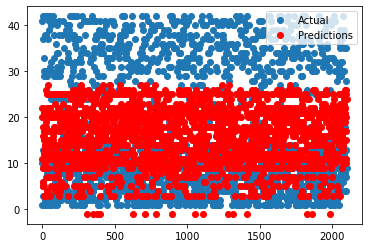

In [30]:
lr_result_df.plot(style=['o','ro'])

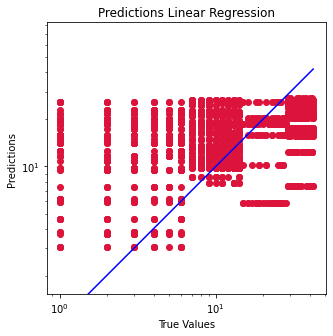

In [31]:
plot_performance_graph('Linear Regression', y_pred, y_test)

In [32]:
rfr_model = RandomForestRegressor(max_depth=20, random_state=0,n_estimators=100)
y_pred, rfr_result_df = train_predict_evaluate(rfr_model, 'Random Forest Regressor', X_train, X_test, y_train, y_test)

Random Forest Regressor
Predictions: [10.57400921 35.42269035  3.26842438 ... 21.07064944 10.32201676
 10.89614212]
Actual: [10 41  1 ... 28 13  9]
Training time: 3.1286349296569824
Predicting time: 0.05385589599609375
Mean Squared Error: 8.509883969629414


In [33]:
rfr_result_df

,Actual,Predictions
0,10,10
1,41,35
2,1,3
3,9,10
4,42,36
...,...,...
2095,4,3
2096,35,36
2097,28,21
2098,13,10


<AxesSubplot:>

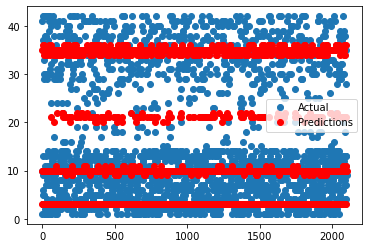

In [34]:
rfr_result_df.plot(style=['o','ro'])

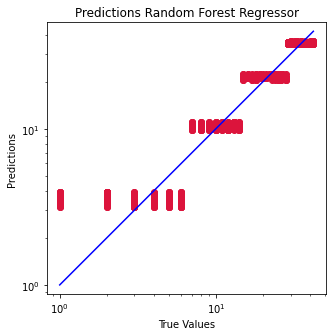

In [35]:
plot_performance_graph('Random Forest Regressor', y_pred, y_test)

In [36]:
svr_model = make_pipeline(StandardScaler(), SVR(C=28, epsilon=0.4))
y_pred, svr_result_df = train_predict_evaluate(svr_model, 'Support Vector Regressor', X_train, X_test, y_train, y_test)

Support Vector Regressor
Predictions: [10.60034044 35.59990156  3.40029475 ... 20.40007428  9.59994349
 11.40005249]
Actual: [10 41  1 ... 28 13  9]
Training time: 11.07501482963562
Predicting time: 6.138585567474365
Mean Squared Error: 12.493440070422977


In [37]:
svr_result_df

,Actual,Predictions
0,10,10
1,41,35
2,1,3
3,9,10
4,42,35
...,...,...
2095,4,3
2096,35,35
2097,28,20
2098,13,9


<AxesSubplot:>

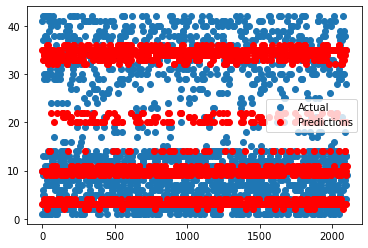

In [38]:
svr_result_df.plot(style=['o','ro'])

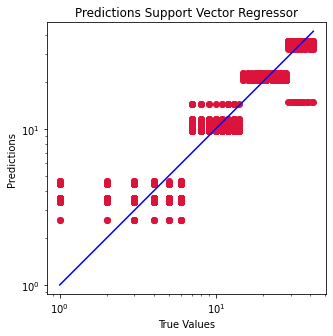

In [39]:
plot_performance_graph('Support Vector Regressor', y_pred, y_test)

In [40]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_oversampled, injury_days, test_size=0.3, random_state=21, shuffle=True)

In [41]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [42]:
X_train.shape

(7350, 51)

In [45]:
#LSTM ANN
checkpoint = callbacks.ModelCheckpoint('lstm_model_s3.h5', 
                                       save_best_only=True)
embedding_size = 128
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.Embedding(X_train.shape[0] + 1, embedding_size, 
                                    input_length=X_train.shape[1]))
model_lstm.add(tf.keras.layers.LSTM(27, return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(27, return_sequences=True))
model_lstm.add(tf.keras.layers.GlobalMaxPool1D())
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(27, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(27, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(1, activation='relu'))

model_lstm.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

start_lstm_train = time.time()

history = model_lstm.fit(X_train, Y_train,
                    epochs=120, 
                    batch_size=128, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_lstm_train = time.time()
lstm_train_time = end_lstm_train - start_lstm_train

Epoch 1/120
58/58 [==============================] - 19s 130ms/step - loss: 379.9456 - accuracy: 0.0297 - val_loss: 268.2910 - val_accuracy: 0.0559
Epoch 2/120
58/58 [==============================] - 7s 119ms/step - loss: 199.7509 - accuracy: 0.0418 - val_loss: 135.4797 - val_accuracy: 0.0559
Epoch 3/120
58/58 [==============================] - 6s 99ms/step - loss: 134.8322 - accuracy: 0.0418 - val_loss: 101.4680 - val_accuracy: 0.0559
Epoch 4/120
58/58 [==============================] - 6s 110ms/step - loss: 119.3941 - accuracy: 0.0418 - val_loss: 95.1158 - val_accuracy: 0.0559
Epoch 5/120
58/58 [==============================] - 6s 111ms/step - loss: 112.0803 - accuracy: 0.0415 - val_loss: 91.3555 - val_accuracy: 0.0559
Epoch 6/120
58/58 [==============================] - 6s 98ms/step - loss: 108.6943 - accuracy: 0.0418 - val_loss: 89.3198 - val_accuracy: 0.0559
Epoch 7/120
58/58 [==============================] - 7s 118ms/step - loss: 106.5680 - accuracy: 0.0418 - val_loss: 87.2092

58/58 [==============================] - 6s 100ms/step - loss: 22.7310 - accuracy: 0.0418 - val_loss: 10.8652 - val_accuracy: 0.0559
Epoch 114/120
58/58 [==============================] - 7s 120ms/step - loss: 22.7541 - accuracy: 0.0415 - val_loss: 11.0915 - val_accuracy: 0.0559
Epoch 115/120
58/58 [==============================] - 6s 103ms/step - loss: 21.7069 - accuracy: 0.0418 - val_loss: 11.2079 - val_accuracy: 0.0559
Epoch 116/120
58/58 [==============================] - 8s 138ms/step - loss: 20.9777 - accuracy: 0.0415 - val_loss: 12.1369 - val_accuracy: 0.0559
Epoch 117/120
58/58 [==============================] - 7s 117ms/step - loss: 23.0814 - accuracy: 0.0415 - val_loss: 11.8100 - val_accuracy: 0.0559
Epoch 118/120
58/58 [==============================] - 8s 136ms/step - loss: 23.4807 - accuracy: 0.0418 - val_loss: 10.8614 - val_accuracy: 0.0559
Epoch 119/120
58/58 [==============================] - 6s 106ms/step - loss: 22.0126 - accuracy: 0.0418 - val_loss: 11.3930 - val_ac

In [46]:
model_lstm = tf.keras.models.load_model('lstm_model_s3.h5')
start_lstm_pred = time.time()
y_pred = model_lstm.predict(X_test)
end_lstm_pred = time.time()
lstm_pred_time = end_lstm_pred - start_lstm_pred

In [47]:
model_lstm.evaluate(X_test, Y_test)[1]

50/50 [==============================] - 3s 17ms/step - loss: 10.7355 - accuracy: 0.0463


0.04634920507669449

In [48]:
y_pred = get_predictions(y_pred)

In [49]:
y_pred, lstm_result_df = plot_results_NN('LSTM', X_train, X_test, Y_train, Y_test, y_pred, lstm_train_time, lstm_pred_time)

LSTM
Predictions: [3.7247787, 3.7247787, 34.43704, 33.7281, 21.365381, 10.410152, 36.43695, 3.7247787, 10.691256, 10.648002, 10.5926285, 32.08433, 34.731632, 9.994655, 10.189837, 3.7247787, 34.26489, 4.4283094, 10.694228, 34.18867, 10.332551, 3.7247787, 10.332551, 10.242719, 4.6633034, 34.43704, 34.33532, 34.49769, 32.345608, 32.08433, 10.485744, 34.43704, 10.457434, 34.669624, 3.7247787, 10.648002, 3.7247787, 3.7247787, 10.268901, 34.585976, 11.017717, 10.508149, 3.7247787, 34.43704, 10.707477, 22.647604, 9.994655, 32.786827, 17.36438, 10.887585, 34.669624, 26.257895, 34.267216, 3.7247787, 21.365381, 10.667492, 10.646954, 10.646954, 34.86054, 34.79415, 34.731632, 10.332551, 10.268901, 3.746868, 10.35588, 10.457434, 34.33532, 33.826637, 33.65337, 3.7247787, 34.267216, 33.938213, 10.836667, 33.7281, 21.365381, 3.746868, 3.7247787, 34.43704, 5.711029, 3.7247787, 3.7247787, 3.7247787, 26.257895, 10.691256, 35.6978, 10.691256, 3.7247787, 5.711029, 10.235594, 3.7247787, 3.7247787, 10.691256

In [50]:
 lstm_result_df 

,Actual,Predictions
0,6,3
1,2,3
2,36,34
3,42,33
4,17,21
...,...,...
1570,4,3
1571,38,32
1572,40,32
1573,6,4


<AxesSubplot:>

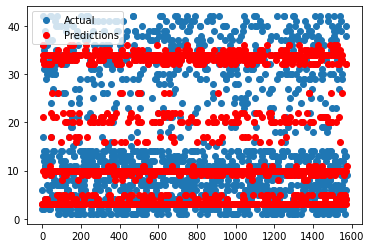

In [51]:
 lstm_result_df.plot(style=['o','ro'])

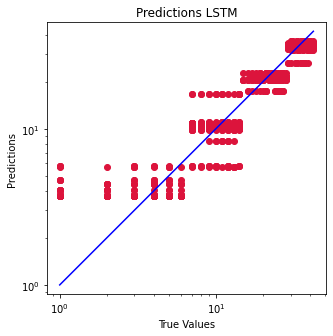

In [52]:
plot_performance_graph('LSTM', y_pred, Y_test)

In [53]:
#GRU ANN
checkpoint = callbacks.ModelCheckpoint('gru_model_s3.h5', 
                                       save_best_only=True)
embedding_size = 128
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.Embedding(X_train.shape[0] + 1, embedding_size, 
                                    input_length=X_train.shape[1]))
model_gru.add(tf.keras.layers.GRU(30, return_sequences=True, input_shape=(59,)))
model_gru.add(tf.keras.layers.GRU(30, return_sequences=True, input_shape=(59,)))
model_gru.add(tf.keras.layers.GlobalMaxPool1D())
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(30, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(30, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(1, activation='relu'))

model_gru.compile(loss='mse', 
              optimizer='adam', 
              metrics=['accuracy'])

start_gru_train = time.time()

history = model_gru.fit(X_train, Y_train, 
                    epochs=120, batch_size=128, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_gru_train = time.time()
gru_train_time = end_gru_train - start_gru_train

Epoch 1/120
58/58 [==============================] - 21s 164ms/step - loss: 334.8548 - accuracy: 0.0316 - val_loss: 170.8260 - val_accuracy: 0.0559
Epoch 2/120
58/58 [==============================] - 7s 127ms/step - loss: 154.5674 - accuracy: 0.0418 - val_loss: 95.9038 - val_accuracy: 0.0559
Epoch 3/120
58/58 [==============================] - 8s 132ms/step - loss: 91.5961 - accuracy: 0.0418 - val_loss: 52.4292 - val_accuracy: 0.0559
Epoch 4/120
58/58 [==============================] - 7s 127ms/step - loss: 73.2570 - accuracy: 0.0418 - val_loss: 47.1314 - val_accuracy: 0.0559
Epoch 5/120
58/58 [==============================] - 8s 142ms/step - loss: 67.1950 - accuracy: 0.0418 - val_loss: 40.3566 - val_accuracy: 0.0559
Epoch 6/120
58/58 [==============================] - 7s 117ms/step - loss: 63.9474 - accuracy: 0.0418 - val_loss: 42.2445 - val_accuracy: 0.0559
Epoch 7/120
58/58 [==============================] - 8s 137ms/step - loss: 62.9650 - accuracy: 0.0418 - val_loss: 39.6786 - va

58/58 [==============================] - 8s 139ms/step - loss: 17.6602 - accuracy: 0.0415 - val_loss: 9.3313 - val_accuracy: 0.0559
Epoch 114/120
58/58 [==============================] - 7s 121ms/step - loss: 17.5680 - accuracy: 0.0416 - val_loss: 9.4044 - val_accuracy: 0.0559
Epoch 115/120
58/58 [==============================] - 8s 135ms/step - loss: 17.6095 - accuracy: 0.0415 - val_loss: 11.2062 - val_accuracy: 0.0559
Epoch 116/120
58/58 [==============================] - 7s 126ms/step - loss: 18.7659 - accuracy: 0.0411 - val_loss: 13.2979 - val_accuracy: 0.0559
Epoch 117/120
58/58 [==============================] - 8s 140ms/step - loss: 17.6262 - accuracy: 0.0414 - val_loss: 10.9353 - val_accuracy: 0.0559
Epoch 118/120
58/58 [==============================] - 8s 133ms/step - loss: 17.6764 - accuracy: 0.0412 - val_loss: 10.6389 - val_accuracy: 0.0559
Epoch 119/120
58/58 [==============================] - 8s 138ms/step - loss: 17.6605 - accuracy: 0.0415 - val_loss: 11.2334 - val_accu

In [54]:
# get the best model from validation
model_gru = tf.keras.models.load_model('gru_model_s3.h5')
start_gru_pred = time.time()
y_pred = model_gru.predict(X_test)
end_gru_pred = time.time()
gru_pred_time = end_gru_pred - start_gru_pred

In [55]:
model_gru.evaluate(X_test, Y_test)[1]

50/50 [==============================] - 3s 24ms/step - loss: 9.5937 - accuracy: 0.0463


0.04634920507669449

In [56]:
y_pred = get_predictions(y_pred)

In [57]:
y_pred, gru_result_df = plot_results_NN('GRU', X_train, X_test, Y_train, Y_test, y_pred, gru_train_time, gru_pred_time)

GRU
Predictions: [3.6059346, 3.999742, 34.549603, 33.943043, 20.431444, 10.075315, 34.991688, 3.5837073, 11.067231, 10.991173, 10.859859, 35.21615, 34.982048, 9.88422, 10.390943, 3.5921822, 33.5867, 3.9380631, 10.37942, 34.455185, 10.348407, 3.6059346, 10.348407, 10.115343, 3.7880716, 34.549603, 33.9987, 34.067295, 34.60811, 35.21615, 10.797085, 34.549603, 10.775422, 34.2569, 3.5725965, 10.991173, 3.999742, 4.0822735, 10.21665, 33.309, 10.980442, 10.466724, 4.1769404, 34.549603, 11.128483, 21.47518, 9.88422, 33.032986, 20.659336, 10.780497, 34.2569, 34.625885, 33.989586, 3.5917664, 20.431444, 10.816994, 11.067449, 11.067449, 34.642464, 34.575222, 34.982048, 10.348407, 10.21665, 3.6084023, 11.336612, 10.775422, 33.9987, 34.668304, 34.970577, 3.5725965, 33.989586, 34.054363, 10.786811, 33.943043, 20.431444, 3.6084023, 3.5790033, 34.549603, 7.2827187, 3.6052508, 3.6298018, 3.999742, 34.625885, 11.067231, 34.391582, 11.067231, 3.6034033, 7.2827187, 10.744725, 3.5790033, 3.6298018, 11.06723

In [58]:
gru_result_df

,Actual,Predictions
0,6,3
1,2,3
2,36,34
3,42,33
4,17,20
...,...,...
1570,4,3
1571,38,35
1572,40,35
1573,6,3


<AxesSubplot:>

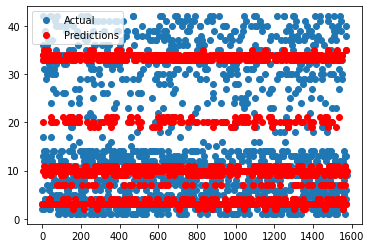

In [59]:
gru_result_df.plot(style=['o','ro'])

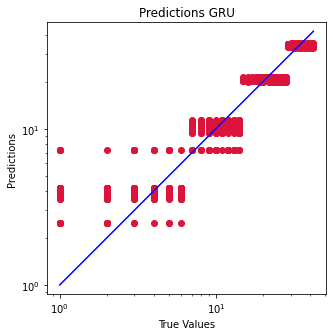

In [60]:
plot_performance_graph('GRU', y_pred, Y_test)

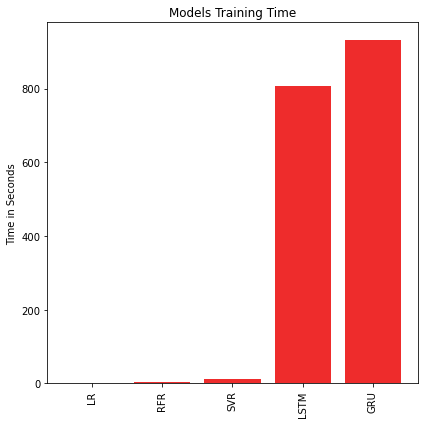

In [61]:
plot_bar_graph(training_times, "Models Training Time" , "Time in Seconds")

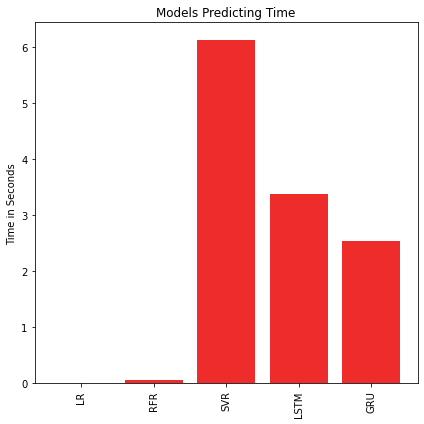

In [62]:
plot_bar_graph(predicting_times, "Models Predicting Time", "Time in Seconds")

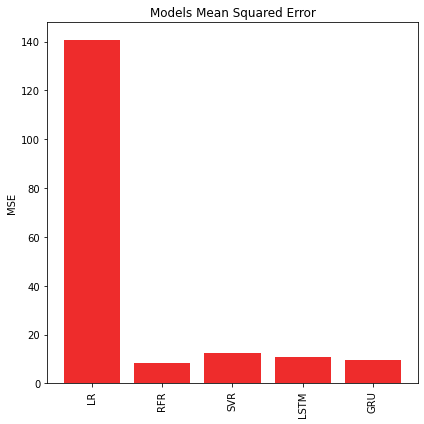

In [63]:
plot_bar_graph(mse_scores, "Models Mean Squared Error", "MSE")